# Illustrate the iEGM through the Buffer-Stock Model

## Monte Carlo Settings

In [1]:
MC_num = 200 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM
specs = { # common specifications across methods
    'rho':1.5,

    'max_C':10.0,
    'max_m':5.0,

    'num_m':150,
    'T': 20,

    'simN':10_000,

} 

## Load relevant packages

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from BufferStockModel import BufferStockModelClass

plt.rcParams.update({'font.size': 14})

## Illustrate the pre-computation of consumption interpolator

In [3]:
# load local model file and initialize model class
SAVE = True
specs_illustrate = {
    'rho':1.5,

    'num_C':10,
    'max_C':5.0,
    'unequal_C':1.5,
}

model = BufferStockModelClass(par=specs_illustrate)
par = model.par

# pre-compute consumption
model.precompute_C()

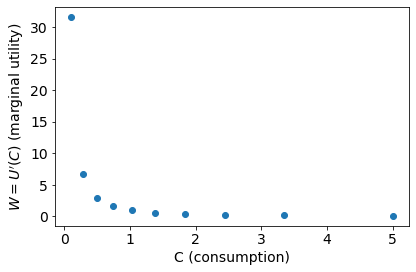

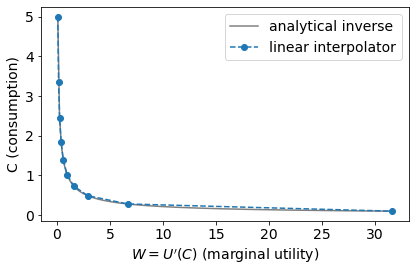

In [4]:
# illustrate the iEGM pre-computation
fig, ax = plt.subplots()
ax.scatter(par.grid_C,par.grid_marg_U)
ax.set(xlabel='C (consumption)',ylabel="$W=U\'(C)$ (marginal utility)");
fig.tight_layout()
fig.savefig('output/fig_illustrate_flip1.pdf')

fig, ax = plt.subplots()
fine_grid = np.linspace(par.grid_marg_U_flip[0],par.grid_marg_U_flip[-1],200)
ax.plot(fine_grid,model.inv_marg_util(fine_grid),color='gray',label='analytical inverse')
ax.plot(par.grid_marg_U_flip,par.grid_C_flip,marker='o',linestyle='--',color='tab:blue',label='linear interpolator');
ax.set(xlabel='$W=U\'(C)$ (marginal utility)',ylabel="C (consumption)");
ax.legend();
fig.tight_layout()
if SAVE: fig.savefig('output/fig_illustrate_flip2.pdf')

## Solve the "true" model using many grid points in VFI

In [5]:
specs_true = specs.copy()
specs_true['num_m'] = 500

model_true = BufferStockModelClass(par=specs_true)
model_true.solve()

Monte Carlo Runs

In [6]:
PRINT = True
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),

    'iegm, Bspline':dict(),
    'iegm, Bspline inverse':dict(),

    'egm, numerical':np.nan + np.zeros(MC_num),
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
    
    'iegm, Bspline':dict(),
    'iegm, Bspline inverse':dict(),

    'egm, numerical':np.nan + np.zeros(MC_num),
}
util = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
    
    'iegm, Bspline':dict(),
    'iegm, Bspline inverse':dict(),

    'egm, numerical':np.nan + np.zeros(MC_num),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, Bspline'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, Bspline'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, Bspline'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, Bspline inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, Bspline inverse'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, Bspline inverse'][num_C] = np.nan + np.zeros(MC_num)

# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    # simulate true model (solved once above)
    model_true.par.seed = i_mc
    model_true.allocate_draws()
    model_true.simulate()
    true_mean_lifetime_util = model_true.sim.mean_lifetime_util

    # setup alternative model solutios
    model = BufferStockModelClass(par=specs)
    model.par.seed = i_mc
    model.allocate()

    # VFI and EGM
    for method in ['vfi','egm']:
        model.par.method = method
        
        # Timing
        t0 = time()
        model.solve()
        timing[model.par.method][i_mc] = time() - t0

        # Accuracy
        model.simulate()
        error[model.par.method][i_mc] = model.sim.mean_log10_euler
        util[model.par.method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    # iEGM
    model.par.method = 'iegm'
    for interp_method in ('linear','Bspline'):
        for interp_inverse in (False,True):
            model.par.interp_method = interp_method
            model.par.interp_inverse = interp_inverse
            method = f'{model.par.method}, {interp_method} inverse' if interp_inverse else f'{model.par.method}, {interp_method}'
            for i_c,num_C in enumerate(C_num_grid):
                model.par.num_C = num_C
                model.allocate()

                # Timing
                t0 = time()
                model.solve()
                timing[method][num_C][i_mc] = time() - t0

                # Accuracy
                model.simulate()
                error[method][num_C][i_mc] = model.sim.mean_log10_euler
                util[method][num_C][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    model.par.interp_method = 'numerical'
    model.par.interp_inverse = False
    method = f'egm, {model.par.interp_method}'
    # Timing
    t0 = time()
    model.solve()
    timing[method][i_mc] = time() - t0

    # Accuracy
    model.simulate()
    error[method][i_mc] = model.sim.mean_log10_euler
    util[method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100


1/200 running...
2/200 running...
3/200 running...
4/200 running...
5/200 running...
6/200 running...
7/200 running...
8/200 running...
9/200 running...
10/200 running...
11/200 running...
12/200 running...
13/200 running...
14/200 running...
15/200 running...
16/200 running...
17/200 running...
18/200 running...
19/200 running...
20/200 running...
21/200 running...
22/200 running...
23/200 running...
24/200 running...
25/200 running...
26/200 running...
27/200 running...
28/200 running...
29/200 running...
30/200 running...
31/200 running...
32/200 running...
33/200 running...
34/200 running...
35/200 running...
36/200 running...
37/200 running...
38/200 running...
39/200 running...
40/200 running...
41/200 running...
42/200 running...
43/200 running...
44/200 running...
45/200 running...
46/200 running...
47/200 running...
48/200 running...
49/200 running...
50/200 running...
51/200 running...
52/200 running...
53/200 running...
54/200 running...
55/200 running...
56/200 running...
5

In [7]:
# print('Euler Error & lifetime util & Timing (rel. to VFI)')
print('lifetime util & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi','egm','egm, numerical'):
    error_now = np.mean(error[method])
    util_now = np.mean(util[method])
    time_now = np.mean(timing[method]) / timing_vfi
    # print(f'{method}: {error_now:2.2f} &  {util_now:2.2f} & {time_now:2.2f} ')
    print(f'{method}: {util_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse','iegm, Bspline','iegm, Bspline inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        error_now = np.mean(error[method][num_C]) 
        util_now = np.mean(util[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        # print(f'{num_C:d} {error_now:2.3f} & {util_now:2.3f} & {time_now:2.3f} ')
        print(f'{num_C:d} {util_now:2.3f} & {time_now:2.3f} ')

lifetime util & Timing (rel. to VFI)
vfi: 0.000 & 1.000 
egm: 0.000 & 0.064 
egm, numerical: 0.000 & 0.112 
iegm, linear: 
20 0.282 & 0.065 
50 0.062 & 0.065 
100 0.011 & 0.065 
200 0.002 & 0.065 
iegm, linear inverse: 
20 0.090 & 0.065 
50 0.011 & 0.065 
100 0.002 & 0.065 
200 0.000 & 0.065 
iegm, Bspline: 
20 0.016 & 0.074 
50 0.001 & 0.074 
100 0.000 & 0.074 
200 0.000 & 0.074 
iegm, Bspline inverse: 
20 0.002 & 0.075 
50 0.000 & 0.075 
100 0.000 & 0.075 
200 0.000 & 0.075 
